In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
hospital_data = pd.read_excel('/content/drive/My Drive/Forecasting model/hospital.xlsx',parse_dates=['Datum'])

In [ ]:
hospital_data = hospital_data.dropna()
hospital_data.columns = ['Date','7-day-hospitalization-incidence']

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Convert the date column to a pandas datetime object
hospital_data['Date'] = pd.to_datetime(hospital_data['Date'])

# Set the date column as the index
hospital_data.set_index('Date', inplace=True)

# Remove the rows with missing values
hospital_data.dropna(inplace=True)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hospital_data.values)

# Define the number of past days to use as input for prediction
look_back = 7

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert the data into sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), :])
        y.append([data[(i+look_back)]])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# Reshape the input data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
8/8 [==============================] - 3s 10ms/step - loss: 0.0501
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 11/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 12/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 13/100
8/8 [==============================] - 0s 8ms

In [ ]:
# Evaluate the LSTM model
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, np.sqrt(train_score)))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, np.sqrt(test_score)))

# Make predictions using the LSTM model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.01 MSE (0.09 RMSE)
4/4 [==============================] - 0s 3ms/step


In [ ]:
# Inverse the scaling to get actual values
train_predict = scaler.inverse_transform(np.concatenate((X_train[:, -1, 0].reshape(-1, 1), train_predict), axis=1))[:, -1]
y_train = scaler.inverse_transform([np.concatenate((X_train[:, -1, 0].reshape(-1, 1), y_train.reshape(-1, 1)), axis=1)[:, -1]])
test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), test_predict), axis=1))[:, -1]
y_test = scaler.inverse_transform([np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1)[:, -1]])

# Remove extra dimension from y_test and test_predict arrays
y_test = np.squeeze(y_test)
test_predict = np.squeeze(test_predict)

In [ ]:
new_test = np.array(y_test)
new_predict = np.array(test_predict)
predictions_df = pd.DataFrame({'Date': hospital_data.index[look_back+train_size:], 'Actual': new_test, 'Predicted': new_predict})

# Set the date column as the index
predictions_df.set_index('Date', inplace=True)

# Print the dataframe
predictions_df[:7]

,Actual,Predicted
Date,,
2022-09-14,3.60,3.315753
2022-09-15,3.65,3.505090
2022-09-16,3.46,3.654320
2022-09-19,3.60,3.657038
2022-09-20,4.33,3.702744
2022-09-21,5.14,4.056354
2022-09-22,5.43,4.648064


<Axes: xlabel='Date'>

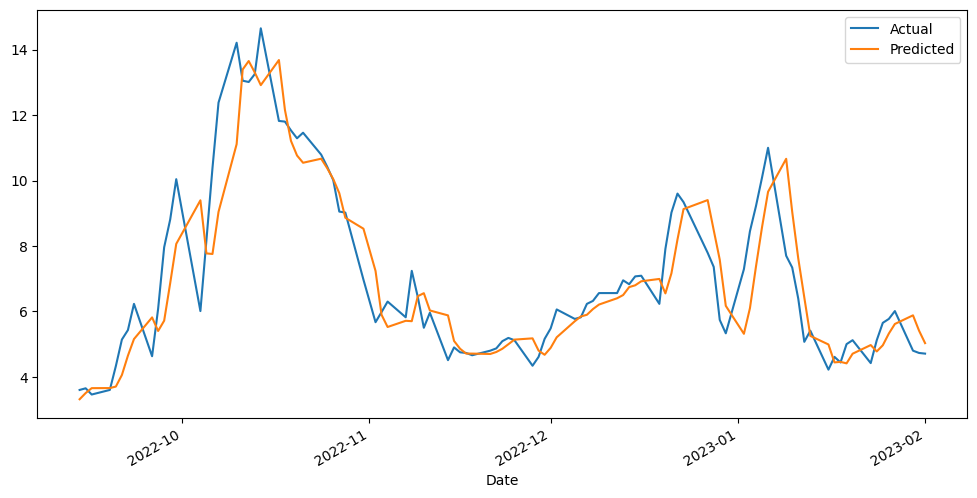

In [ ]:
predictions_df.plot(figsize=(12,6))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Convert the predicted and actual values back to their original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1,1)).ravel()
y_train = scaler.inverse_transform(y_train.reshape(-1,1)).ravel()
test_predict = scaler.inverse_transform(test_predict.reshape(-1,1)).ravel()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

#threshold
threshold = 0.5

# Bin the target values into discrete classes
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Convert predicted values to binary
train_predict_binary = (train_predict > threshold).astype(int)
test_predict_binary = (test_predict > threshold).astype(int)

# Calculate precision, recall, and F1 score
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train_binary, train_predict_binary, average='binary')
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test_binary, test_predict_binary, average='binary')

print('Train Precision:', train_precision)
print('Train Recall:', train_recall)
print('Train F1 Score:', train_f1_score)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1 Score:', test_f1_score)

Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0
